# MLB Wins and Loses Model

In [156]:
%matplotlib inline

In [157]:
from pylab import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D

In [158]:
#Datasets
reg_bat = pd.DataFrame.from_csv('data/batting.csv', index_col = None, encoding = ('utf-8'))
post_bat = pd.DataFrame.from_csv('data/batting_postseason.csv', index_col = None, encoding = ('utf-8'))
reg_pit = pd.DataFrame.from_csv('data/pitching.csv', index_col = None, encoding = ('utf-8'))
post_pit = pd.DataFrame.from_csv('data/pitching_postseason.csv', index_col = None, encoding = ('utf-8'))
post = pd.DataFrame.from_csv('data/postseason.csv', index_col = None, encoding = ('utf-8'))
team = pd.DataFrame.from_csv('data/team.csv', index_col = None, encoding = ('utf-8'))
player = pd.DataFrame.from_csv('data/player.csv', index_col = None, encoding = ('utf-8'))
park = pd.DataFrame.from_csv('data/park.csv', index_col = None, encoding = ('utf-8'))
reg_field = pd.DataFrame.from_csv('data/fielding.csv', index_col = None, encoding = ('utf-8'))
field_out = pd.DataFrame.from_csv('data/fielding_outfield.csv', index_col = None, encoding = ('utf-8'))
post_field = pd.DataFrame.from_csv('data/fielding_postseason.csv', index_col = None, encoding = ('utf-8'))

In [159]:
# Only includes players that had 80 or more at bats in a season
#reg_bat = reg_bat.loc[reg_bat['ab']>=(400),:]

In [160]:
####### Column Labeling #######

#Regular Season Batting
reg_bat = reg_bat.fillna(0)
r_ab = reg_bat['ab']
r_bb = reg_bat['bb']
r_hbp = reg_bat['hbp']
r_ibb = reg_bat['ibb']
r_sf = reg_bat['sf']
r_sh = reg_bat['sh']
r_h = reg_bat['h']
r_dou = reg_bat['double']
r_tri = reg_bat['triple']
r_hr = reg_bat['hr']
r_sin = r_h - (r_dou + r_tri + r_hr)
rb_teamid = reg_bat['team_id']
r_bso = reg_bat['so']
r_sb = reg_bat['sb']
#Postseason Batting
post_bat = post_bat.fillna(0)
p_ab = post_bat['ab']
p_bb = post_bat['bb']
p_hbp = post_bat['hbp']
p_ibb = post_bat['ibb']
p_sf = post_bat['sf']
p_sh = post_bat['sh']
p_h = post_bat['h']
p_dou = post_bat['double']
p_tri = post_bat['triple']
p_hr = post_bat['hr']
p_sin = p_h - (p_dou + p_tri + p_hr)
pb_teamid = post_bat['team_id']
p_bso = post_bat['so']
p_sb = post_bat['sb']

In [161]:
####### Individual PLayer Statistic Calculations #######

#Batting Average
reg_bat['bat_avg'] = r_h/r_ab
post_bat['bat_avg'] = p_h/p_ab
#Slugging Percentage
reg_bat['slg'] = (r_sin + 2*r_dou + 3*r_tri + 4*r_hr)/r_ab
r_slg = reg_bat['slg']
post_bat['slg'] = (p_sin + 2*p_dou + 3*p_tri + 4*p_hr)/p_ab
p_slg = post_bat['slg']
#On Base Percentage
reg_bat['obp'] = (r_h + r_bb + r_hbp)/(r_ab + r_bb + r_hbp + r_sf)
r_obp = reg_bat['obp']
post_bat['obp'] = (p_h + p_bb + p_hbp)/(p_ab + p_bb + p_hbp + p_sf)
p_obp = post_bat['obp']
#On Base PLus Slugging
reg_bat['ops'] = r_slg + r_obp
r_ops = reg_bat['ops']
post_bat['ops'] = p_slg + p_obp
p_ops = post_bat['ops']
#Weighted On Base Average
reg_bat['woba'] = (.69*r_bb + .72*r_hbp + .89*r_sin + 1.27*r_dou + 1.62*r_tri + 2.10*r_hr)/(r_ab + r_bb + r_ibb + r_sf + r_hbp)
r_woba = reg_bat['woba']
post_bat['woba'] = (.69*p_bb + .72*p_hbp + .89*p_sin + 1.27*p_dou + 1.62*p_tri + 2.10*p_hr)/(p_ab + p_bb + p_ibb + p_sf + p_hbp)
p_woba = post_bat['woba']
#Strikeout Percentage
reg_bat['kperc'] = r_bso / (r_ab + r_bb + r_hbp + r_sf + r_sh)
r_kperc = reg_bat['kperc']
post_bat['kperc'] = p_bso / (p_ab + p_bb + p_hbp + p_sf + p_sh)
p_kperc = post_bat['kperc']

In [162]:
####### Team Tabels #######

#Team Groupby
team_reg_bat = reg_bat.groupby(['team_id', 'year'])['ab', 'r', 'h', 'double', 'triple', 'hr','rbi', 'sb', 'cs', 'so', 'bb', 'ibb', 'hbp', 'sh', 'sf'].sum().reset_index()
team_post_bat = post_bat.groupby(['team_id', 'year'])['ab', 'r', 'h', 'double', 'triple', 'hr', 'rbi', 'sb', 'cs', 'so', 'bb', 'ibb', 'hbp', 'sh', 'sf'].sum().reset_index()

In [163]:
t_reg = team[['team_id', 'year', 'franchise_id', 'w', 'l']]
t_post = post[['team_id_winner', 'year', 'wins', 'losses']]
t_post.columns = ['team_id', 'year', 'w', 'l']

In [164]:
team_rb = pd.merge(team_reg_bat, t_reg, how='left', left_on=['team_id', 'year'], right_on=['team_id', 'year'])
team_rb = team_rb.loc[team_rb['year'] >= 1990, :]

In [165]:
team_pb = pd.merge(team_post_bat, t_post, how='left', left_on=['team_id', 'year'], right_on=['team_id', 'year'])
team_pb = team_pb.loc[team_pb['year'] >= 1990, :]

In [166]:
####### Team Column Labeling #######

#Team Regular Season Batting
team_reg_bat = team_reg_bat.fillna(0)
tr_ab = team_rb['ab']
tr_bb = team_rb['bb']
tr_hbp = team_rb['hbp']
tr_ibb = team_rb['ibb']
tr_sf = team_rb['sf']
tr_sh = team_rb['sh']
tr_h = team_rb['h']
tr_dou = team_rb['double']
tr_tri = team_rb['triple']
tr_hr = team_rb['hr']
tr_sin = tr_h - (tr_dou + tr_tri + tr_hr)
trb_teamid = team_rb['team_id']
tr_bso = team_rb['so'].dropna()
tr_sb = team_rb['sb']
#Team Postseason Batting
team_post_bat = team_post_bat.fillna(0)
tp_ab = team_pb['ab']
tp_bb = team_pb['bb']
tp_hbp = team_pb['hbp']
tp_ibb = team_pb['ibb']
tp_sf = team_pb['sf']
tp_sh = team_pb['sh']
tp_h = team_pb['h']
tp_dou = team_pb['double']
tp_tri = team_pb['triple']
tp_hr = team_pb['hr']
tp_sin = tp_h - (tp_dou + tp_tri + tp_hr)
tpb_teamid = team_pb['team_id']
tp_bso = team_pb['so']
tp_sb = team_pb['sb']

In [167]:
####### Team Batting Statistic Calculations #######

#Batting Average
team_rb['bat_avg'] = tr_h/tr_ab
tr_avg = team_rb['bat_avg']
team_pb['bat_avg'] = tp_h/tp_ab
tp_avg = team_pb['bat_avg']
#Slugging Percentage
team_rb['slg'] = (tr_sin + 2*tr_dou + 3*tr_tri + 4*tr_hr)/tr_ab
tr_slg = team_rb['slg']
team_pb['slg'] = (tp_sin + 2*tp_dou + 3*tp_tri + 4*tp_hr)/tp_ab
tp_slg = team_pb['slg']
#On Base Percentage
team_rb['obp'] = (tr_h + tr_bb + tr_hbp)/(tr_ab + tr_bb + tr_hbp + tr_sf)
tr_obp = team_rb['obp']
team_pb['obp'] = (tp_h + tp_bb + tp_hbp)/(tp_ab + tp_bb + tp_hbp + tp_sf)
tp_obp = team_pb['obp']
#On Base PLus Slugging
team_rb['ops'] = tr_slg + tr_obp
tr_ops = team_rb['ops']
team_pb['ops'] = tp_slg + tp_obp
tp_ops = team_pb['ops']
#Weighted On Base Average
team_rb['woba'] = (.69*tr_bb + .72*tr_hbp + .89*tr_sin + 1.27*tr_dou + 1.62*tr_tri + 2.10*tr_hr)/(tr_ab + tr_bb + tr_ibb + tr_sf + tr_hbp)
tr_woba = team_rb['woba']
team_pb['woba'] = (.69*tp_bb + .72*tp_hbp + .89*tp_sin + 1.27*tp_dou + 1.62*tp_tri + 2.10*tp_hr)/(tp_ab + tp_bb + tp_ibb + tp_sf + tp_hbp)
tp_woba = team_pb['woba']
#Strikeout Percentage
team_rb['kperc'] = tr_bso / (tr_ab + tr_bb + tr_hbp + tr_sf + tr_sh)
tr_kperc = team_rb['kperc']
team_pb['kperc'] = tp_bso / (tp_ab + tp_bb + tp_hbp + tp_sf + tp_sh)
tp_kperc = team_pb['kperc']

In [168]:
# Delete Outliers in Stats
team_rb_h = team_rb.loc[((team_rb.h >= np.mean(tr_h)-3*np.std(tr_h)) & (team_rb.h <= np.mean(tr_h)+3*np.std(tr_h))), :]
team_rb_d = team_rb.loc[((team_rb.double >= np.mean(tr_dou)-3*np.std(tr_dou)) & (team_rb.double <= np.mean(tr_dou)+3*np.std(tr_dou))), :]
team_rb_t = team_rb.loc[((team_rb.triple >= np.mean(tr_tri)-3*np.std(tr_tri)) & (team_rb.triple <= np.mean(tr_tri)+3*np.std(tr_tri))), :]
team_rb_hr = team_rb.loc[((team_rb.hr >= np.mean(tr_hr)-3*np.std(tr_hr)) & (team_rb.hr <= np.mean(tr_hr)+3*np.std(tr_hr))), :]
team_rb_so = team_rb.loc[((team_rb.so >= np.mean(tr_bso)-3*np.std(tr_bso)) & (team_rb.so <= np.mean(tr_bso)+3*np.std(tr_bso))), :]
team_rb_bb = team_rb.loc[((team_rb.bb >= np.mean(tr_bb)-3*np.std(tr_bb)) & (team_rb.bb <= np.mean(tr_bb)+3*np.std(tr_bb))), :]
team_rb_h = team_rb.loc[((team_rb.h >= np.mean(tr_h)-3*np.std(tr_h)) & (team_rb.h <= np.mean(tr_h)+3*np.std(tr_h))), :]
team_rb_hr.loc[team_rb_hr.hr == 32]

,team_id,year,ab,r,h,double,triple,hr,rbi,sb,...,sf,franchise_id,w,l,bat_avg,slg,obp,ops,woba,kperc


In [169]:
# Deleting outliers in calculated stats
team_rb_avg = team_rb.loc[((team_rb.bat_avg >= np.mean(tr_avg)-3*np.std(tr_avg)) & (team_rb.bat_avg <= np.mean(tr_avg)+3*np.std(tr_avg))), :]
team_rb_slg = team_rb.loc[((team_rb.slg >= np.mean(tr_slg)-3*np.std(tr_slg)) & (team_rb.slg <= np.mean(tr_slg)+3*np.std(tr_slg))), :]
team_rb_obp = team_rb.loc[((team_rb.obp >= np.mean(tr_obp)-3*np.std(tr_obp)) & (team_rb.obp <= np.mean(tr_obp)+3*np.std(tr_obp))), :]
team_rb_ops = team_rb.loc[((team_rb.ops >= np.mean(tr_ops)-3*np.std(tr_ops)) & (team_rb.ops <= np.mean(tr_ops)+3*np.std(tr_ops))), :]
team_rb_woba = team_rb.loc[((team_rb.woba >= np.mean(tr_woba)-3*np.std(tr_woba)) & (team_rb.woba <= np.mean(tr_woba)+3*np.std(tr_woba))), :]
team_rb_kperc = team_rb.loc[((team_rb.kperc >= np.mean(tr_kperc)-3*np.std(tr_kperc)) & (team_rb.kperc <= np.mean(tr_kperc)+3*np.std(tr_kperc))), :]

In [170]:
fig = plt.figure()

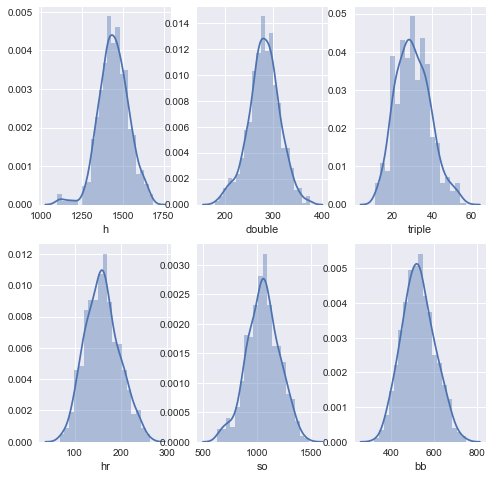

In [171]:
####### DISTRIBUTION PLOTS FOR TEAM OFFENSIVE STATS #######

fig, ax = plt.subplots(2,3,figsize=(8,8))

sns.distplot(team_rb_h.h, ax=ax[0,0])
sns.distplot(team_rb_d.double, ax=ax[0,1])
sns.distplot(team_rb_t.triple, ax=ax[0,2])
sns.distplot(team_rb_hr.hr, ax=ax[1,0])
sns.distplot(team_rb_so.so, ax=ax[1,1])
sns.distplot(team_rb_bb.bb, ax=ax[1,2])
None

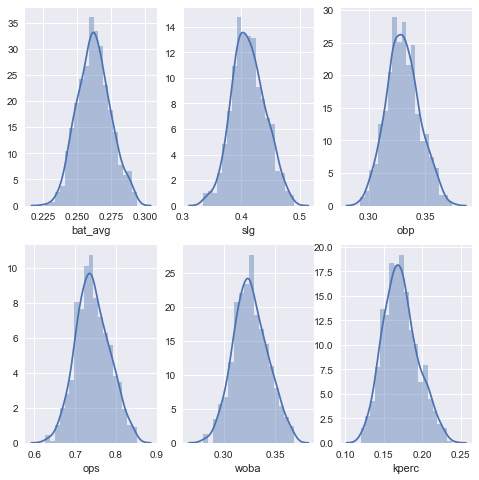

In [172]:
####### DISTRIBUTION PLOTS FOR TEAM CALCULATED OFFENSIVE STATS #######

fig, ax = plt.subplots(2,3,figsize=(8,8))

sns.distplot(team_rb_avg.bat_avg, ax=ax[0,0])
sns.distplot(team_rb_slg.slg, ax=ax[0,1])
sns.distplot(team_rb_obp.obp, ax=ax[0,2])
sns.distplot(team_rb_ops.ops, ax=ax[1,0])
sns.distplot(team_rb_woba.woba, ax=ax[1,1])
sns.distplot(team_rb_kperc.kperc, ax=ax[1,2])
None

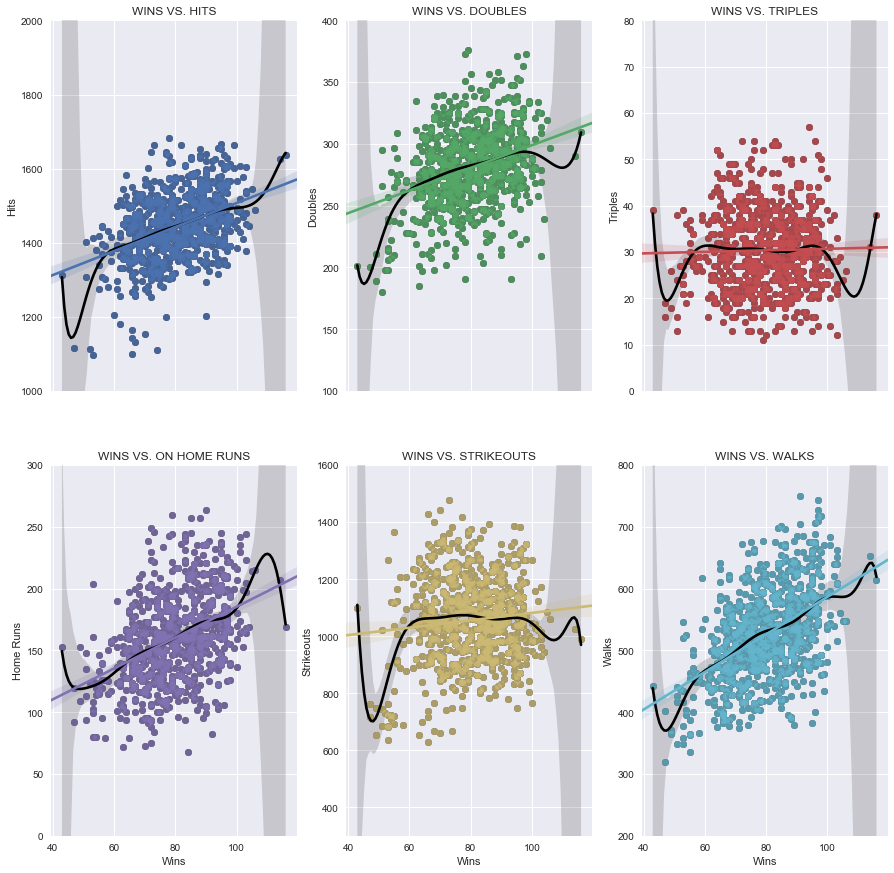

In [173]:
####### REGULAR SEASON STATS TO WINS #######

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

# Hits Scatter
sns.regplot(x='w', y='h', data=team_rb_h, ax=ax[0,0], order=10, truncate=True, color='black')
sns.regplot(x='w', y='h', data=team_rb_h, ax=ax[0,0])
ax[0,0].set_title('WINS VS. HITS')
ax[0,0].set_ylabel('Hits')
ax[0,0].set_xlabel('')
ax[0,0].set_ylim([1000,2000])
h_slope, h_intercept, h_r_value, h_p_value, h_slope_std_error = scipy.stats.linregress(team_rb_h.w, team_rb_h.h)

# Doubles Scatter
sns.regplot(x='w', y='double', data=team_rb_d, ax=ax[0,1], order=10, truncate=True, color='black')
sns.regplot(x='w', y='double', data=team_rb_d, ax=ax[0,1])
ax[0,1].set_title('WINS VS. DOUBLES')
ax[0,1].set_ylabel('Doubles')
ax[0,1].set_xlabel('')
ax[0,1].set_ylim([100,400])
d_slope, d_intercept, d_r_value, d_p_value, d_slope_std_error = scipy.stats.linregress(team_rb_d.w, team_rb_d.double)

# Triples Scatter
sns.regplot(x='w', y='triple', data=team_rb_t, ax=ax[0,2], order=10, truncate=True, color='black')
sns.regplot(x='w', y='triple', data=team_rb_t, ax=ax[0,2])
ax[0,2].set_title('WINS VS. TRIPLES')
ax[0,2].set_ylabel('Triples')
ax[0,2].set_xlabel('')
ax[0,2].set_ylim([0,80])
t_slope, t_intercept, t_r_value, t_p_value, t_slope_std_error = scipy.stats.linregress(team_rb_t.w, team_rb_t.triple)

# Home Runs Scatter
sns.regplot(x='w', y='hr', data=team_rb_hr, ax=ax[1,0], order=10, truncate=True, color='black')
sns.regplot(x='w', y='hr', data=team_rb_hr, ax=ax[1,0])
ax[1,0].set_title('WINS VS. ON HOME RUNS')
ax[1,0].set_ylabel('Home Runs')
ax[1,0].set_xlabel('Wins')
ax[1,0].set_ylim([0,300])
hr_slope, hr_intercept, hr_r_value, hr_p_value, hr_slope_std_error = scipy.stats.linregress(team_rb_hr.w, team_rb_hr.hr)

# Strikeouts Scatter
sns.regplot(x='w', y='so', data=team_rb_so, ax=ax[1,1], order=10, truncate=True, color='black')
sns.regplot(x='w', y='so', data=team_rb_so, ax=ax[1,1])
ax[1,1].set_title('WINS VS. STRIKEOUTS')
ax[1,1].set_ylabel('Strikeouts')
ax[1,1].set_xlabel('Wins')
ax[1,1].set_ylim([300,1600])
so_slope, so_intercept, so_r_value, so_p_value, so_slope_std_error = scipy.stats.linregress(team_rb_so.w, team_rb_so.so)

# Walks Scatter
sns.regplot(x='w', y='bb', data=team_rb_bb, ax=ax[1,2], order=10, truncate=True, color='black')
sns.regplot(x='w', y='bb', data=team_rb_bb, ax=ax[1,2])
ax[1,2].set_title('WINS VS. WALKS')
ax[1,2].set_ylabel('Walks')
ax[1,2].set_xlabel('Wins')
ax[1,2].set_ylim([200,800])
bb_slope, bb_intercept, bb_r_value, bb_p_value, bb_slope_std_error = scipy.stats.linregress(team_rb_bb.w, team_rb_bb.bb)

In [174]:
print('HITS REGRESSION')
print('Slope:', h_slope)
print('Intercept:', h_intercept)
print('R value:', h_r_value)
print('P value:', h_p_value)
print('Slope Standard Deviation Error:', h_slope_std_error)
print('')
print('DOUBLES REGRESSION')
print('Slope:', d_slope)
print('Intercept:', d_intercept)
print('R value:', d_r_value)
print('P value:', d_p_value)
print('Slope Standard Deviation Error:', d_slope_std_error)
print('')
print('TRIPLES REGRESSION')
print('Slope:', t_slope)
print('Intercept:', t_intercept)
print('R value:', t_r_value)
print('P value:', t_p_value)
print('Slope Standard Deviation Error:', t_slope_std_error)
print('')
print('HOME RUNS REGRESSION')
print('Slope:', hr_slope)
print('Intercept:', hr_intercept)
print('R value:', hr_r_value)
print('P value:', hr_p_value)
print('Slope Standard Deviation Error:', hr_slope_std_error)
print('')
print('STRIKEOUTS REGRESSION')
print('Slope:', so_slope)
print('Intercept:', so_intercept)
print('R value:', so_r_value)
print('P value:', so_p_value)
print('Slope Standard Deviation Error:', so_slope_std_error)
print('')
print('WALKS REGRESSION')
print('Slope:', bb_slope)
print('Intercept:', bb_intercept)
print('R value:', bb_r_value)
print('P value:', bb_p_value)
print('Slope Standard Deviation Error:', bb_slope_std_error)
print('')
None

HITS REGRESSION
Slope: 3.24026887052
Intercept: 1183.21605592
R value: 0.401756571621
P value: 4.89178689533e-30
Slope Standard Deviation Error: 0.27205679906

DOUBLES REGRESSION
Slope: 0.916331109101
Intercept: 207.367141027
R value: 0.335800762448
P value: 2.81043894934e-21
Slope Standard Deviation Error: 0.0938555915379

TRIPLES REGRESSION
Slope: 0.0164240117676
Intercept: 29.0569818303
R value: 0.0229781492359
P value: 0.528698017934
Slope Standard Deviation Error: 0.0260579711252

HOME RUNS REGRESSION
Slope: 1.25018770776
Intercept: 60.3900431271
R value: 0.411406749854
P value: 2.53628864071e-32
Slope Standard Deviation Error: 0.100734131786

STRIKEOUTS REGRESSION
Slope: 1.29865556197
Intercept: 952.001720856
R value: 0.103872866034
P value: 0.00430034895831
Slope Standard Deviation Error: 0.453447788091

WALKS REGRESSION
Slope: 3.04159605764
Intercept: 282.706456803
R value: 0.483874655494
P value: 1.44605071723e-45
Slope Standard Deviation Error: 0.20046906964



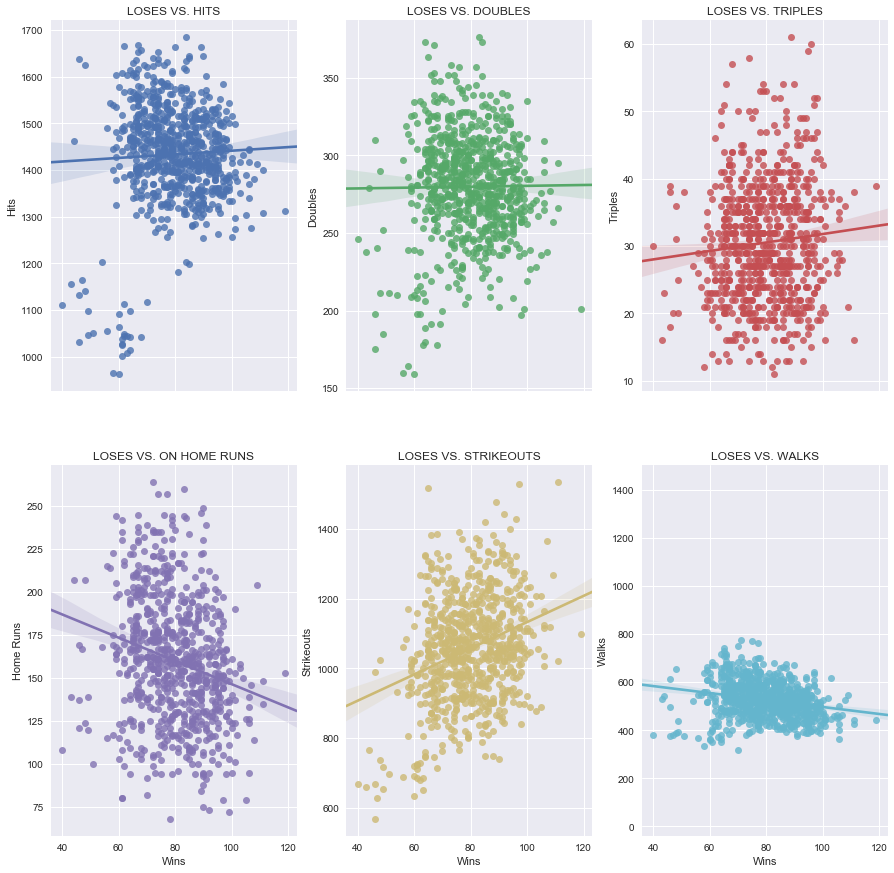

In [175]:
####### REGULAR SEASON STATS TO LOSES #######

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

sns.regplot(x='l', y='h', data=team_rb, ax=ax[0,0])
ax[0,0].set_title('LOSES VS. HITS')
ax[0,0].set_ylabel('Hits')
ax[0,0].set_xlabel('')

sns.regplot(x='l', y='double', data=team_rb, ax=ax[0,1])
ax[0,1].set_title('LOSES VS. DOUBLES')
ax[0,1].set_ylabel('Doubles')
ax[0,1].set_xlabel('')

sns.regplot(x='l', y='triple', data=team_rb, ax=ax[0,2])
ax[0,2].set_title('LOSES VS. TRIPLES')
ax[0,2].set_ylabel('Triples')
ax[0,2].set_xlabel('')

sns.regplot(x='l', y='hr', data=team_rb, ax=ax[1,0])
ax[1,0].set_title('LOSES VS. ON HOME RUNS')
ax[1,0].set_ylabel('Home Runs')
ax[1,0].set_xlabel('Wins')

sns.regplot(x='l', y='so', data=team_rb, ax=ax[1,1])
ax[1,1].set_title('LOSES VS. STRIKEOUTS')
ax[1,1].set_ylabel('Strikeouts')
ax[1,1].set_xlabel('Wins')

sns.regplot(x='l', y='bb', data=team_rb, ax=ax[1,2])
ax[1,2].set_title('LOSES VS. WALKS')
ax[1,2].set_ylabel('Walks')
ax[1,2].set_xlabel('Wins')
None

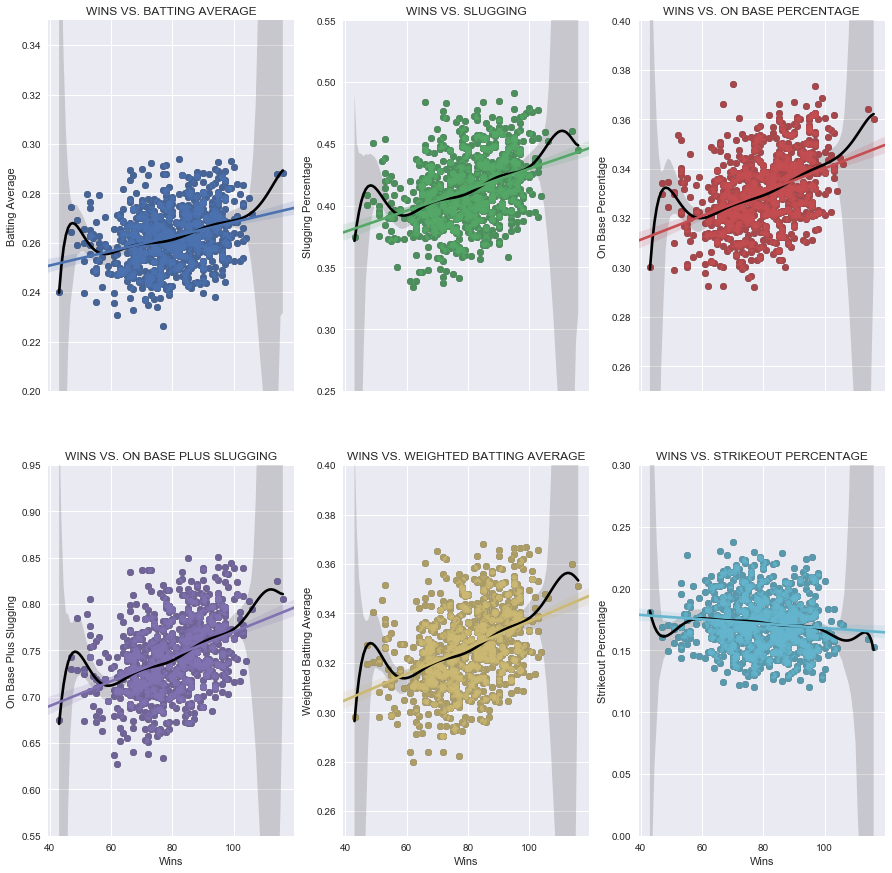

In [176]:
####### REGULAR SEASON CALCUALTED STATS TO WINS #######

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

sns.regplot(x='w', y='bat_avg', data=team_rb_avg, ax=ax[0,0], order=10, truncate=True, color='black')
sns.regplot(x='w', y='bat_avg', data=team_rb_avg, ax=ax[0,0])
ax[0,0].set_title('WINS VS. BATTING AVERAGE')
ax[0,0].set_ylabel('Batting Average')
ax[0,0].set_xlabel('')
ax[0,0].set_ylim([.2,.35])
avg_slope, avg_intercept, avg_r_value, avg_p_value, avg_slope_std_error = scipy.stats.linregress(team_rb_avg.w, team_rb_avg.bat_avg)

sns.regplot(x='w', y='slg', data=team_rb_slg, ax=ax[0,1], order=10, truncate=True, color='black')
sns.regplot(x='w', y='slg', data=team_rb_slg, ax=ax[0,1])
ax[0,1].set_title('WINS VS. SLUGGING')
ax[0,1].set_ylabel('Slugging Percentage')
ax[0,1].set_xlabel('')
ax[0,1].set_ylim([.25,.55])
slg_slope, slg_intercept, slg_r_value, slg_p_value, slg_slope_std_error = scipy.stats.linregress(team_rb_slg.w, team_rb_slg.slg)

sns.regplot(x='w', y='obp', data=team_rb_obp, ax=ax[0,2], order=10, truncate=True, color='black')
sns.regplot(x='w', y='obp', data=team_rb_obp, ax=ax[0,2])
ax[0,2].set_title('WINS VS. ON BASE PERCENTAGE')
ax[0,2].set_ylabel('On Base Percentage')
ax[0,2].set_xlabel('')
ax[0,2].set_ylim([.25,.4])
obp_slope, obp_intercept, obp_r_value, obp_p_value, obp_slope_std_error = scipy.stats.linregress(team_rb_obp.w, team_rb_obp.obp)

sns.regplot(x='w', y='ops', data=team_rb_ops, ax=ax[1,0], order=10, truncate=True, color='black')
sns.regplot(x='w', y='ops', data=team_rb_ops, ax=ax[1,0])
ax[1,0].set_title('WINS VS. ON BASE PLUS SLUGGING')
ax[1,0].set_ylabel('On Base Plus Slugging')
ax[1,0].set_xlabel('Wins')
ax[1,0].set_ylim([.55,.95])
ops_slope, ops_intercept, ops_r_value, ops_p_value, ops_slope_std_error = scipy.stats.linregress(team_rb_ops.w, team_rb_ops.ops)

sns.regplot(x='w', y='woba', data=team_rb_woba, ax=ax[1,1], order=10, truncate=True, color='black')
sns.regplot(x='w', y='woba', data=team_rb_woba, ax=ax[1,1])
ax[1,1].set_title('WINS VS. WEIGHTED BATTING AVERAGE')
ax[1,1].set_ylabel('Weighted Batting Average')
ax[1,1].set_xlabel('Wins')
ax[1,1].set_ylim([.25,.4])
woba_slope, woba_intercept, woba_r_value, woba_p_value, woba_slope_std_error = scipy.stats.linregress(team_rb_woba.w, team_rb_woba.woba)

sns.regplot(x='w', y='kperc', data=team_rb_kperc, ax=ax[1,2], order=10, truncate=True, color='black')
sns.regplot(x='w', y='kperc', data=team_rb_kperc, ax=ax[1,2])
ax[1,2].set_title('WINS VS. STRIKEOUT PERCENTAGE')
ax[1,2].set_ylabel('Strikeout Percentage')
ax[1,2].set_xlabel('Wins')
ax[1,2].set_ylim([0,.3])
kperc_slope, kperc_intercept, kperc_r_value, kperc_p_value, kperc_slope_std_error = scipy.stats.linregress(team_rb_kperc.w, team_rb_kperc.kperc)
None

In [177]:
print('BATTING AVERAGE REGRESSION')
print('Slope:', avg_slope)
print('Intercept:', avg_intercept)
print('R value:', avg_r_value)
print('P value:', avg_p_value)
print('Slope Standard Deviation Error:', avg_slope_std_error)
print('')
print('SLUGGING REGRESSION')
print('Slope:', slg_slope)
print('Intercept:', slg_intercept)
print('R value:', slg_r_value)
print('P value:', slg_p_value)
print('Slope Standard Deviation Error:', slg_slope_std_error)
print('')
print('ON BASE REGRESSION')
print('Slope:', obp_slope)
print('Intercept:', obp_intercept)
print('R value:', obp_r_value)
print('P value:', obp_p_value)
print('Slope Standard Deviation Error:', obp_slope_std_error)
print('')
print('ON BASE PLUS SLUG REGRESSION')
print('Slope:', ops_slope)
print('Intercept:', ops_intercept)
print('R value:', ops_r_value)
print('P value:', ops_p_value)
print('Slope Standard Deviation Error:', ops_slope_std_error)
print('')
print('WIEGHTED ON BASE REGRESSION')
print('Slope:', woba_slope)
print('Intercept:', woba_intercept)
print('R value:', woba_r_value)
print('P value:', woba_p_value)
print('Slope Standard Deviation Error:', woba_slope_std_error)
print('')
print('K PERCENTAGE REGRESSION')
print('Slope:', kperc_slope)
print('Intercept:', kperc_intercept)
print('R value:', kperc_r_value)
print('P value:', kperc_p_value)
print('Slope Standard Deviation Error:', kperc_slope_std_error)
print('')
None

BATTING AVERAGE REGRESSION
Slope: 0.00029227943858
Intercept: 0.239131126221
R value: 0.293699115795
P value: 1.51310012097e-16
Slope Standard Deviation Error: 3.45976215112e-05

SLUGGING REGRESSION
Slope: 0.000849515059556
Intercept: 0.344960768437
R value: 0.360746684116
P value: 1.03225712865e-24
Slope Standard Deviation Error: 7.9879065154e-05

ON BASE REGRESSION
Slope: 0.000481172721356
Intercept: 0.292008183564
R value: 0.39270249511
P value: 2.34211281243e-29
Slope Standard Deviation Error: 4.09832471587e-05

ON BASE PLUS SLUG REGRESSION
Slope: 0.00133068778091
Intercept: 0.636968952001
R value: 0.392537643617
P value: 2.4826216865e-29
Slope Standard Deviation Error: 0.000113395838667

WIEGHTED ON BASE REGRESSION
Slope: 0.000530433647382
Intercept: 0.283681515511
R value: 0.390423074584
P value: 5.22641684331e-29
Slope Standard Deviation Error: 4.54906804444e-05

K PERCENTAGE REGRESSION
Slope: -0.000176755089317
Intercept: 0.185836610871
R value: -0.096319096126
P value: 0.00813

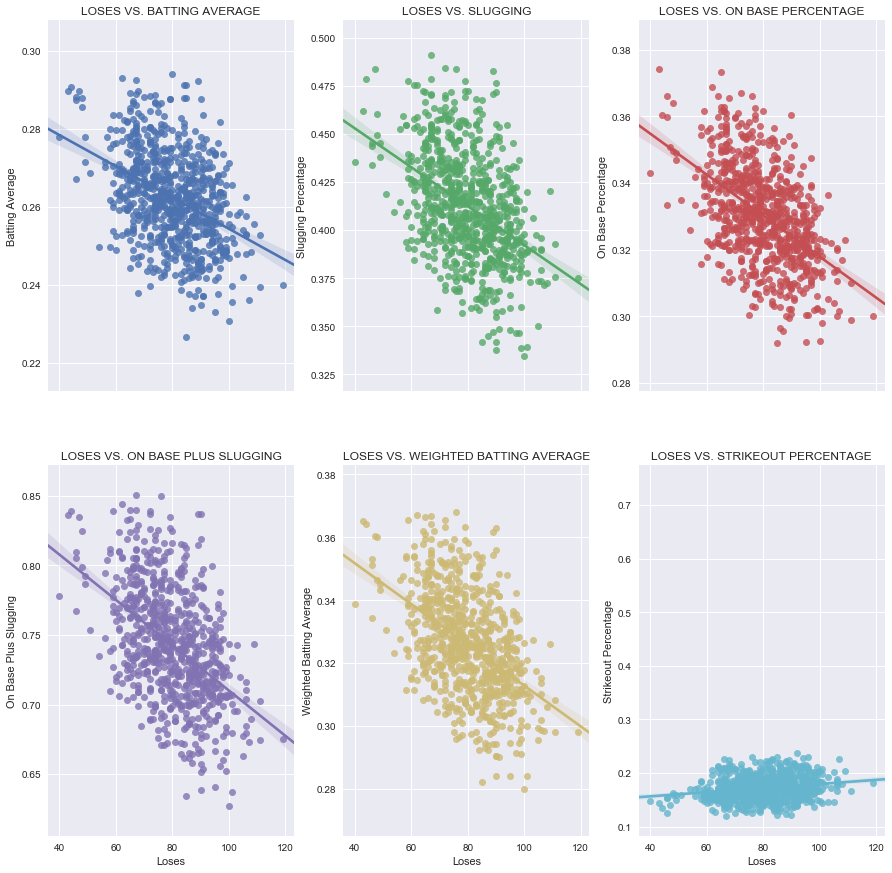

In [185]:
####### REGULAR SEASON CALCUALTED STATS TO WINS #######

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

sns.regplot(x='l', y='bat_avg', data=team_rb_avg, ax=ax[0,0])
ax[0,0].set_title('LOSES VS. BATTING AVERAGE')
ax[0,0].set_ylabel('Batting Average')
ax[0,0].set_xlabel('')
avg_slope, avg_intercept, avg_r_value, avg_p_value, avg_slope_std_error = scipy.stats.linregress(team_rb_avg.l, team_rb_avg.bat_avg)

sns.regplot(x='l', y='slg', data=team_rb_slg, ax=ax[0,1])
ax[0,1].set_title('LOSES VS. SLUGGING')
ax[0,1].set_ylabel('Slugging Percentage')
ax[0,1].set_xlabel('')

sns.regplot(x='l', y='obp', data=team_rb_obp, ax=ax[0,2])
ax[0,2].set_title('LOSES VS. ON BASE PERCENTAGE')
ax[0,2].set_ylabel('On Base Percentage')
ax[0,2].set_xlabel('')

sns.regplot(x='l', y='ops', data=team_rb_ops, ax=ax[1,0])
ax[1,0].set_title('LOSES VS. ON BASE PLUS SLUGGING')
ax[1,0].set_ylabel('On Base Plus Slugging')
ax[1,0].set_xlabel('Loses')

sns.regplot(x='l', y='woba', data=team_rb_woba, ax=ax[1,1])
ax[1,1].set_title('LOSES VS. WEIGHTED BATTING AVERAGE')
ax[1,1].set_ylabel('Weighted Batting Average')
ax[1,1].set_xlabel('Loses')

sns.regplot(x='l', y='kperc', data=team_rb_kperc, ax=ax[1,2])
ax[1,2].set_title('LOSES VS. STRIKEOUT PERCENTAGE')
ax[1,2].set_ylabel('Strikeout Percentage')
ax[1,2].set_xlabel('Loses')

slg_slope, slg_intercept, slg_r_value, slg_p_value, slg_slope_std_error = scipy.stats.linregress(team_rb_slg.l, team_rb_slg.slg)

obp_slope, obp_intercept, obp_r_value, obp_p_value, obp_slope_std_error = scipy.stats.linregress(team_rb_obp.l, team_rb_obp.obp)

ops_slope, ops_intercept, ops_r_value, ops_p_value, ops_slope_std_error = scipy.stats.linregress(team_rb_ops.l, team_rb_ops.ops)

woba_slope, woba_intercept, woba_r_value, woba_p_value, woba_slope_std_error = scipy.stats.linregress(team_rb_woba.l, team_rb_woba.woba)

kperc_slope, kperc_intercept, kperc_r_value, kperc_p_value, kperc_slope_std_error = scipy.stats.linregress(team_rb_kperc.l, team_rb_kperc.kperc)

None

In [186]:
print('BATTING AVERAGE REGRESSION')
print('Slope:', avg_slope)
print('Intercept:', avg_intercept)
print('R value:', avg_r_value)
print('P value:', avg_p_value)
print('Slope Standard Deviation Error:', avg_slope_std_error)
print('')
print('SLUGGING REGRESSION')
print('Slope:', slg_slope)
print('Intercept:', slg_intercept)
print('R value:', slg_r_value)
print('P value:', slg_p_value)
print('Slope Standard Deviation Error:', slg_slope_std_error)
print('')
print('ON BASE REGRESSION')
print('Slope:', obp_slope)
print('Intercept:', obp_intercept)
print('R value:', obp_r_value)
print('P value:', obp_p_value)
print('Slope Standard Deviation Error:', obp_slope_std_error)
print('')
print('ON BASE PLUS SLUG REGRESSION')
print('Slope:', ops_slope)
print('Intercept:', ops_intercept)
print('R value:', ops_r_value)
print('P value:', ops_p_value)
print('Slope Standard Deviation Error:', ops_slope_std_error)
print('')
print('WIEGHTED ON BASE REGRESSION')
print('Slope:', woba_slope)
print('Intercept:', woba_intercept)
print('R value:', woba_r_value)
print('P value:', woba_p_value)
print('Slope Standard Deviation Error:', woba_slope_std_error)
print('')
print('K PERCENTAGE REGRESSION')
print('Slope:', kperc_slope)
print('Intercept:', kperc_intercept)
print('R value:', kperc_r_value)
print('P value:', kperc_p_value)
print('Slope Standard Deviation Error:', kperc_slope_std_error)
print('')
None

BATTING AVERAGE REGRESSION
Slope: -0.000400350620157
Intercept: 0.294369744045
R value: -0.401570254044
P value: 9.71055662262e-31
Slope Standard Deviation Error: 3.32071875275e-05

SLUGGING REGRESSION
Slope: -0.00101267560212
Intercept: 0.49347415878
R value: -0.429257871553
P value: 2.47408436646e-35
Slope Standard Deviation Error: 7.74937081711e-05

ON BASE REGRESSION
Slope: -0.000615494376706
Intercept: 0.37946955482
R value: -0.501422025599
P value: 1.66648751944e-49
Slope Standard Deviation Error: 3.86258207253e-05

ON BASE PLUS SLUG REGRESSION
Slope: -0.00162816997883
Intercept: 0.872943713599
R value: -0.479425952787
P value: 8.0453866066e-45
Slope Standard Deviation Error: 0.00010839398373

WIEGHTED ON BASE REGRESSION
Slope: -0.000648065250173
Intercept: 0.377669134713
R value: -0.476145629176
P value: 3.76095884428e-44
Slope Standard Deviation Error: 4.35299254543e-05

K PERCENTAGE REGRESSION
Slope: 0.000384448795156
Intercept: 0.141093673464
R value: 0.208930805816
P value: 

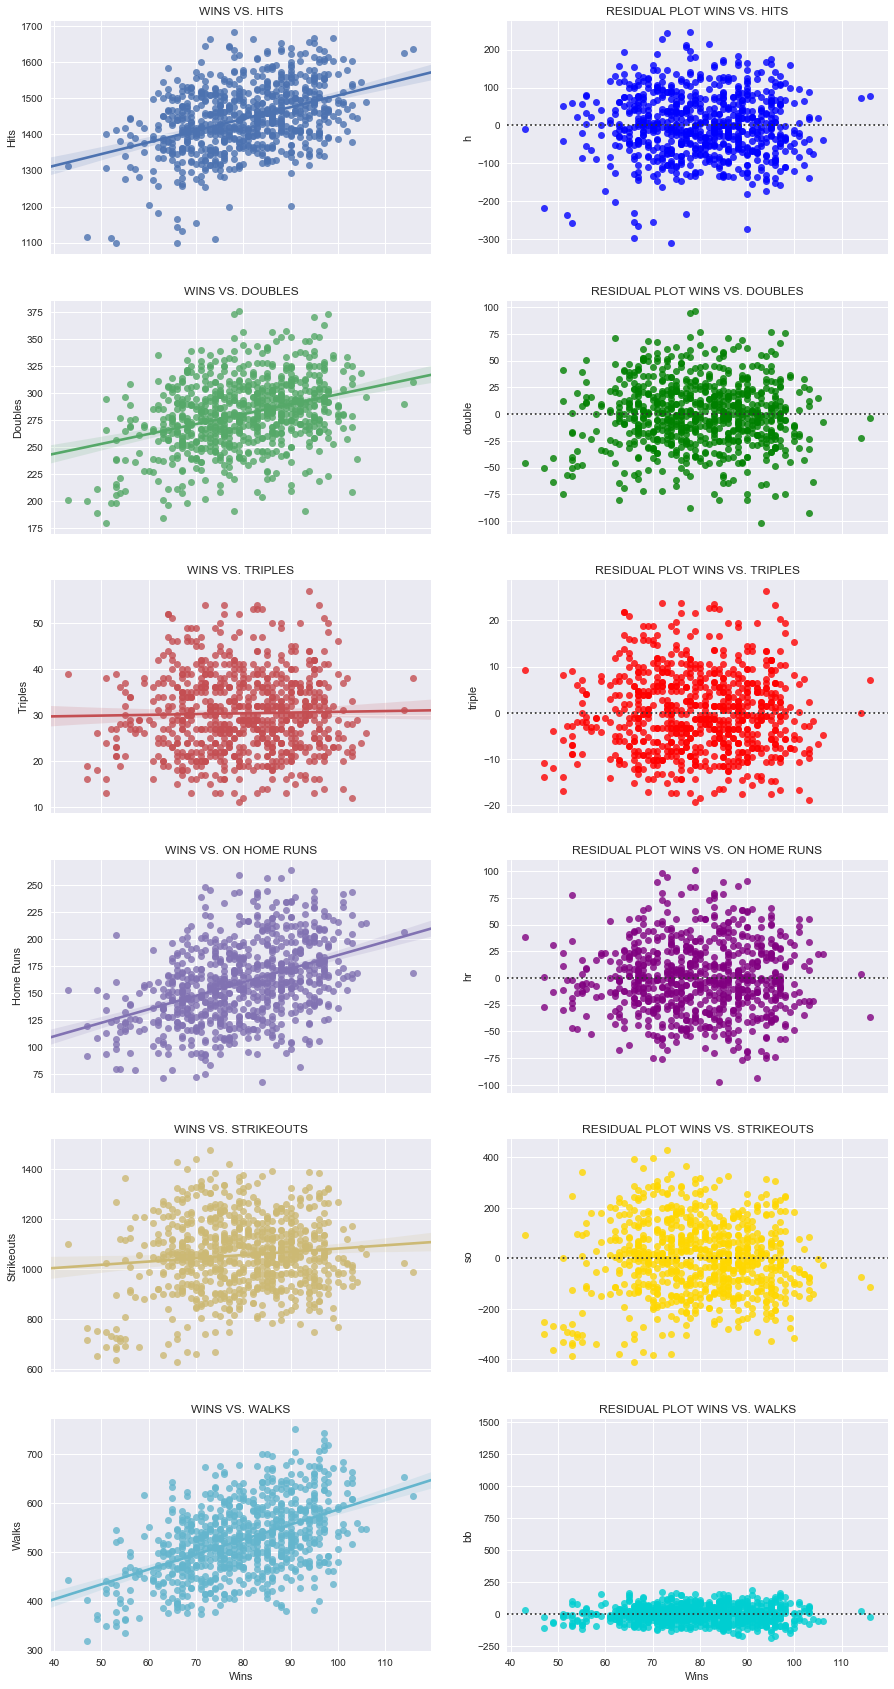

In [179]:
fig, ax = plt.subplots(6,2,figsize=(15,30), sharex = True)

sns.regplot(x='w', y='h', data=team_rb_h, ax=ax[0,0])
ax[0,0].set_title('WINS VS. HITS')
ax[0,0].set_ylabel('Hits')
ax[0,0].set_xlabel('')

sns.residplot(x='w', y='h', data=team_rb_h, ax=ax[0,1], color = 'blue')
ax[0,1].set_title('RESIDUAL PLOT WINS VS. HITS')
ax[0,1].set_xlabel('')

sns.regplot(x='w', y='double', data=team_rb_d, ax=ax[1,0])
ax[1,0].set_title('WINS VS. DOUBLES')
ax[1,0].set_ylabel('Doubles')
ax[1,0].set_xlabel('')

sns.residplot(x='w', y='double', data=team_rb_d, ax=ax[1,1], color = 'green')
ax[1,1].set_title('RESIDUAL PLOT WINS VS. DOUBLES')
ax[1,1].set_xlabel('')

sns.regplot(x='w', y='triple', data=team_rb_t, ax=ax[2,0])
ax[2,0].set_title('WINS VS. TRIPLES')
ax[2,0].set_ylabel('Triples')
ax[2,0].set_xlabel('')

sns.residplot(x='w', y='triple', data=team_rb_t, ax=ax[2,1], color = 'red')
ax[2,1].set_title('RESIDUAL PLOT WINS VS. TRIPLES')
ax[2,1].set_xlabel('')

sns.regplot(x='w', y='hr', data=team_rb_hr, ax=ax[3,0])
ax[3,0].set_title('WINS VS. ON HOME RUNS')
ax[3,0].set_ylabel('Home Runs')
ax[3,0].set_xlabel('')

sns.residplot(x='w', y='hr', data=team_rb_hr, ax=ax[3,1], color = 'purple')
ax[3,1].set_title('RESIDUAL PLOT WINS VS. ON HOME RUNS')
ax[3,1].set_xlabel('')

sns.regplot(x='w', y='so', data=team_rb_so, ax=ax[4,0])
ax[4,0].set_title('WINS VS. STRIKEOUTS')
ax[4,0].set_ylabel('Strikeouts')
ax[4,0].set_xlabel('')

sns.residplot(x='w', y='so', data=team_rb_so, ax=ax[4,1], color = 'gold')
ax[4,1].set_title('RESIDUAL PLOT WINS VS. STRIKEOUTS')
ax[4,1].set_xlabel('')

sns.regplot(x='w', y='bb', data=team_rb_bb, ax=ax[5,0])
ax[5,0].set_title('WINS VS. WALKS')
ax[5,0].set_ylabel('Walks')
ax[5,0].set_xlabel('Wins')

sns.residplot(x='w', y='bb', data=team_rb_bb, ax=ax[5,1], color = 'darkturquoise')
ax[5,1].set_title('RESIDUAL PLOT WINS VS. WALKS')
ax[5,1].set_xlabel('Wins')
None

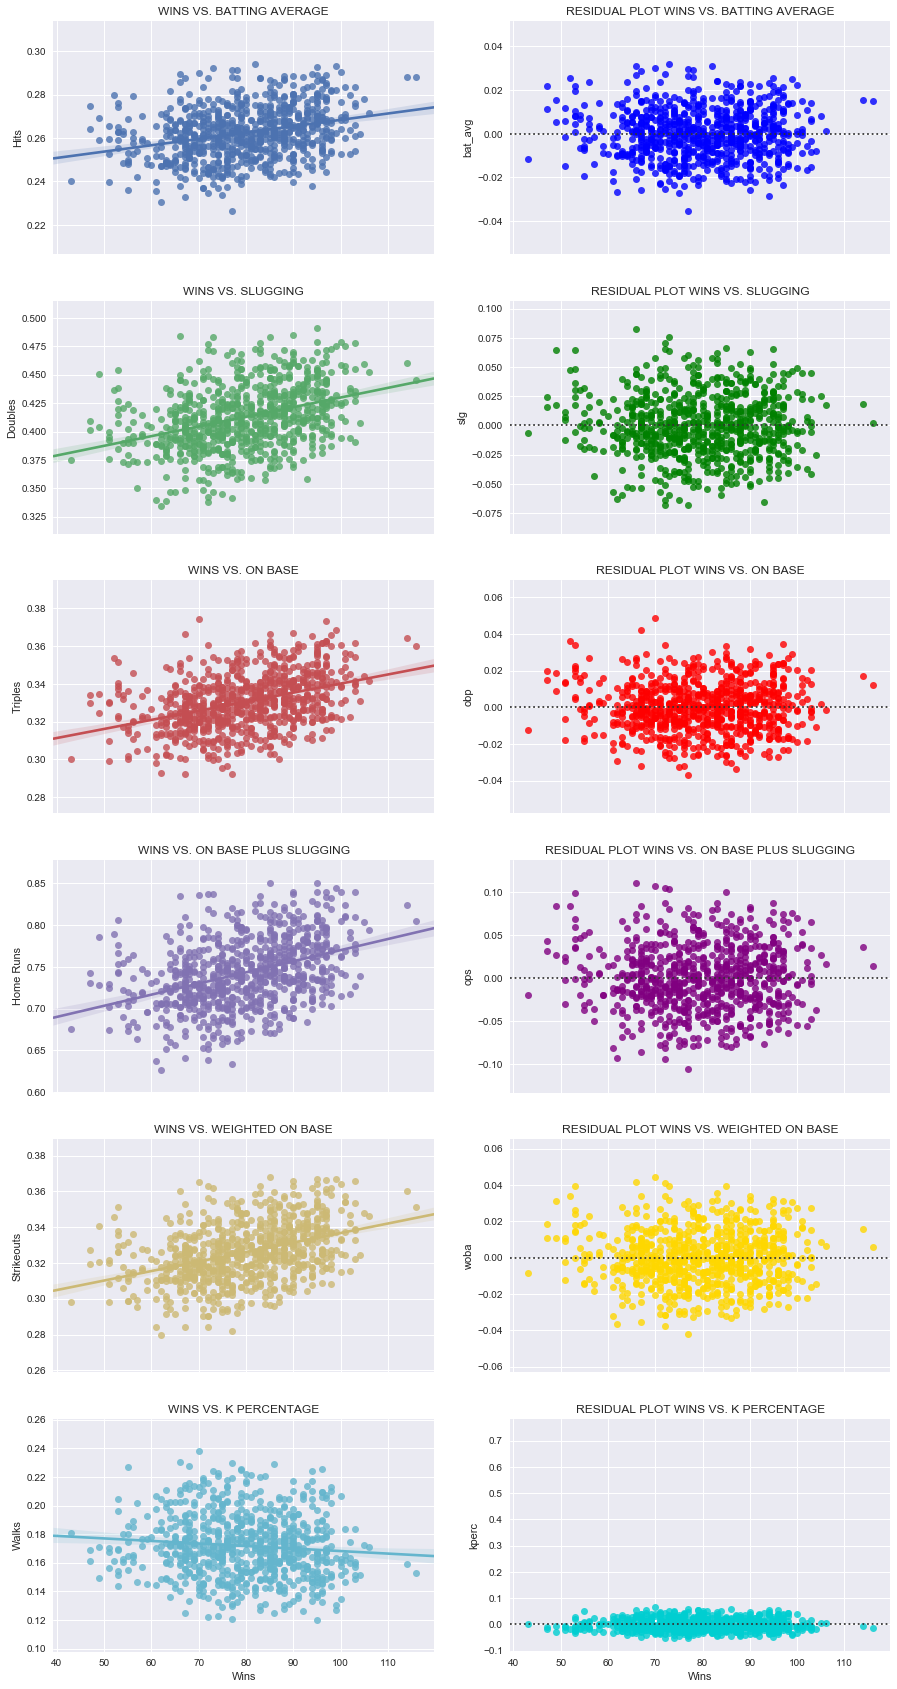

In [180]:
fig, ax = plt.subplots(6,2,figsize=(15,30), sharex = True)

sns.regplot(x='w', y='bat_avg', data=team_rb_avg, ax=ax[0,0])
ax[0,0].set_title('WINS VS. BATTING AVERAGE')
ax[0,0].set_ylabel('Hits')
ax[0,0].set_xlabel('')

sns.residplot(x='w', y='bat_avg', data=team_rb_avg, ax=ax[0,1], color = 'blue')
ax[0,1].set_title('RESIDUAL PLOT WINS VS. BATTING AVERAGE')
ax[0,1].set_xlabel('')

sns.regplot(x='w', y='slg', data=team_rb_slg, ax=ax[1,0])
ax[1,0].set_title('WINS VS. SLUGGING')
ax[1,0].set_ylabel('Doubles')
ax[1,0].set_xlabel('')

sns.residplot(x='w', y='slg', data=team_rb_slg, ax=ax[1,1], color = 'green')
ax[1,1].set_title('RESIDUAL PLOT WINS VS. SLUGGING')
ax[1,1].set_xlabel('')

sns.regplot(x='w', y='obp', data=team_rb_obp, ax=ax[2,0])
ax[2,0].set_title('WINS VS. ON BASE')
ax[2,0].set_ylabel('Triples')
ax[2,0].set_xlabel('')

sns.residplot(x='w', y='obp', data=team_rb_obp, ax=ax[2,1], color = 'red')
ax[2,1].set_title('RESIDUAL PLOT WINS VS. ON BASE')
ax[2,1].set_xlabel('')

sns.regplot(x='w', y='ops', data=team_rb_slg, ax=ax[3,0])
ax[3,0].set_title('WINS VS. ON BASE PLUS SLUGGING')
ax[3,0].set_ylabel('Home Runs')
ax[3,0].set_xlabel('')

sns.residplot(x='w', y='ops', data=team_rb_slg, ax=ax[3,1], color = 'purple')
ax[3,1].set_title('RESIDUAL PLOT WINS VS. ON BASE PLUS SLUGGING')
ax[3,1].set_xlabel('')

sns.regplot(x='w', y='woba', data=team_rb_woba, ax=ax[4,0])
ax[4,0].set_title('WINS VS. WEIGHTED ON BASE')
ax[4,0].set_ylabel('Strikeouts')
ax[4,0].set_xlabel('')

sns.residplot(x='w', y='woba', data=team_rb_woba, ax=ax[4,1], color = 'gold')
ax[4,1].set_title('RESIDUAL PLOT WINS VS. WEIGHTED ON BASE')
ax[4,1].set_xlabel('')

sns.regplot(x='w', y='kperc', data=team_rb_kperc, ax=ax[5,0])
ax[5,0].set_title('WINS VS. K PERCENTAGE')
ax[5,0].set_ylabel('Walks')
ax[5,0].set_xlabel('Wins')

sns.residplot(x='w', y='kperc', data=team_rb_kperc, ax=ax[5,1], color = 'darkturquoise')
ax[5,1].set_title('RESIDUAL PLOT WINS VS. K PERCENTAGE')
ax[5,1].set_xlabel('Wins')
None

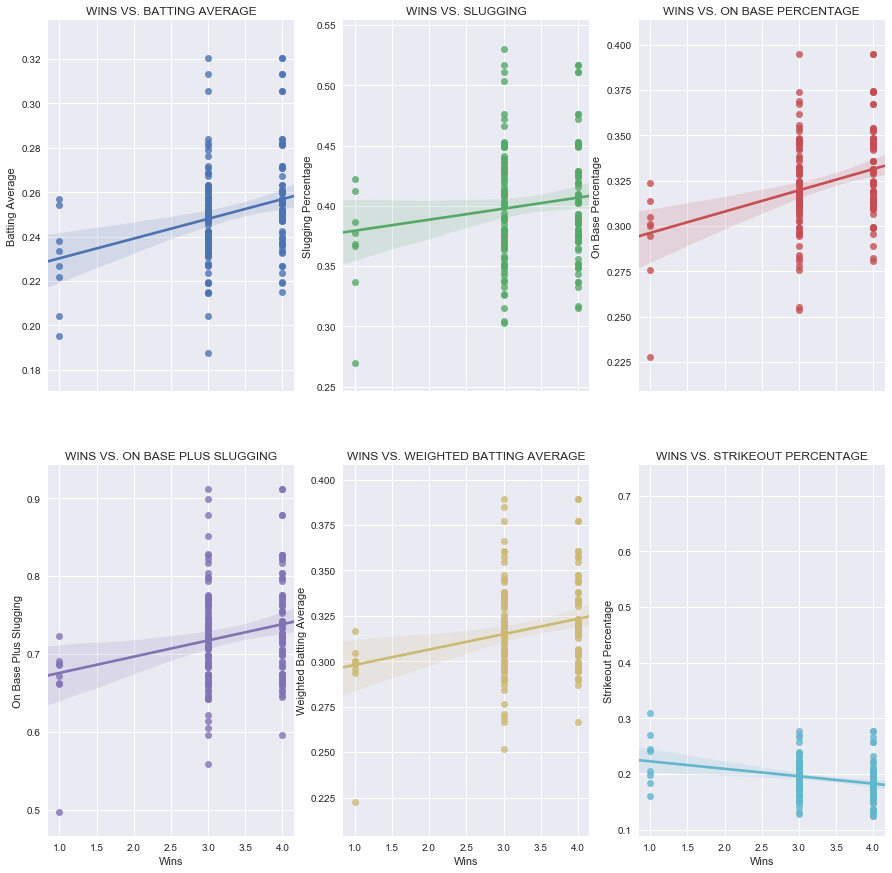

In [181]:
####### POSTSEASON STATS TO WINS ########

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

sns.regplot(x='w', y='bat_avg', data=team_pb, ax=ax[0,0])
ax[0,0].set_title('WINS VS. BATTING AVERAGE')
ax[0,0].set_ylabel('Batting Average')
ax[0,0].set_xlabel('')

sns.regplot(x='w', y='slg', data=team_pb, ax=ax[0,1])
ax[0,1].set_title('WINS VS. SLUGGING')
ax[0,1].set_ylabel('Slugging Percentage')
ax[0,1].set_xlabel('')

sns.regplot(x='w', y='obp', data=team_pb, ax=ax[0,2])
ax[0,2].set_title('WINS VS. ON BASE PERCENTAGE')
ax[0,2].set_ylabel('On Base Percentage')
ax[0,2].set_xlabel('')

sns.regplot(x='w', y='ops', data=team_pb, ax=ax[1,0])
ax[1,0].set_title('WINS VS. ON BASE PLUS SLUGGING')
ax[1,0].set_ylabel('On Base Plus Slugging')
ax[1,0].set_xlabel('Wins')

sns.regplot(x='w', y='woba', data=team_pb, ax=ax[1,1])
ax[1,1].set_title('WINS VS. WEIGHTED BATTING AVERAGE')
ax[1,1].set_ylabel('Weighted Batting Average')
ax[1,1].set_xlabel('Wins')

sns.regplot(x='w', y='kperc', data=team_pb, ax=ax[1,2])
ax[1,2].set_title('WINS VS. STRIKEOUT PERCENTAGE')
ax[1,2].set_ylabel('Strikeout Percentage')
ax[1,2].set_xlabel('Wins')
None

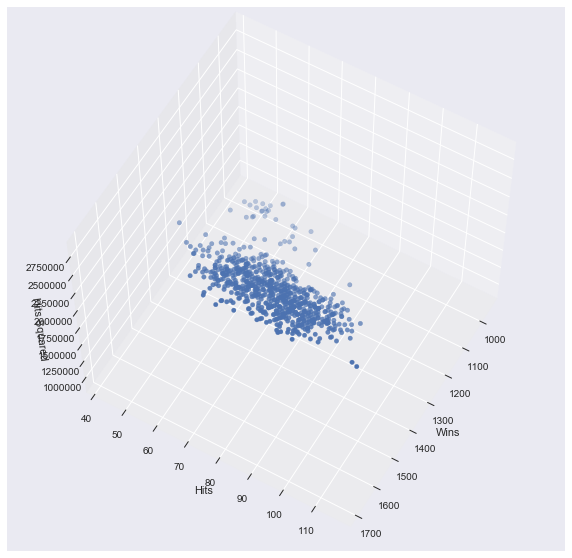

In [182]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

h2 = team_rb.h * team_rb.h
w = team_rb.w
h = team_rb.h

ax.scatter(h, w, h2,)
ax.set_title('')
ax.set_ylabel('Hits')
ax.set_xlabel('Wins')
ax.set_zlabel('Hits Squared')
ax.view_init(60, 30)
None